# **Hackmageddon.**
El CSV se centra en incidentes de ciberseguridad, específicamente en ataques de secuestro de cuentas.

## Importación de librerias.

In [289]:
# === Librerías estándar de Python ===
import os
import numpy as np

# === Librerías de análisis de datos y visualización ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Librerías de preprocesamiento de datos ===
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from urllib.parse import urlparse

# === Librerías para aprendizaje supervisado ===
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# === Librerías para métricas de evaluación ===
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_score,
    recall_score,
)

# === Librerías para aprendizaje no supervisado ===
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# === Librerías para balanceo de datos ===
from imblearn.over_sampling import RandomOverSampler

# === Librerías adicionales ===
from tabulate import tabulate

# === Configuración de colores ===
denexus_colors = ['#1B2D40', '#577596', '#C7262B', '#F85C37', '#FF8250', '#4A4A4A']
denexus_palette = sns.light_palette("#1B2D40", n_colors=100, as_cmap=True)

## Importación e información del DataFrame.

In [290]:
df = pd.read_csv('data/HACKMAGEDDON.csv')
df

,Date Reported,Date Occurred,Date Discovered,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags
0,2020-01-02 00:00:00,NaN,NaN,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President..."
1,2020-01-02 00:00:00,NaN,NaN,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office
2,2020-01-03 00:00:00,NaN,NaN,?,Alomere Health,"The personal and medical information of 49,351...",Account Hijacking,Q Human health and social work activities,CC,US,https://www.bleepingcomputer.com/news/security...,Alomere Health
3,2020-01-03 00:00:00,NaN,NaN,?,Contra Costa County Library System,The Contra Costa County Library System is hit ...,Malware,"O Public administration and defence, compulsor...",CC,US,https://www.govtech.com/security/Bay-Area-Libr...,"The Contra Costa County Library System, ransom..."
4,2020-01-03 00:00:00,NaN,NaN,?,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,Malware,Q Human health and social work activities,CC,US,https://www.databreaches.net/native-american-r...,"Native American Rehabilitation Association, Em..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4957,2022-01-12 00:00:00,Since 26/10/2021,-,?,Multiple Organizations,Researchers from Cisco Talos discover a new ca...,Malware,Multiple Industries,CC,>1,https://www.zdnet.com/article/remote-access-tr...,"Cisco Talos, Nanocore, Netwire, AsyncRAT"
4958,2022-01-12 00:00:00,During January 2021,During January 2021,?,OneDigital,"OneDigital, an insurance broker, discloses a r...",Malware,"Professional, scientific and technical",CC,US,https://www.hipaajournal.com/phi-of-anthem-mem...,"OneDigital, ransomware"
4959,2022-01-13 00:00:00,During November 2021,During November 2021,BlueNoroff,Cryptocurrency startups,Researchers from Kaspersky discover SnatchCryp...,Malware,Fintech,CC,>1,https://www.bleepingcomputer.com/news/security...,"Kaspersky, 'BlueNoroff', MetaMask, SnatchCrypto"
4960,2022-01-13 00:00:00,Since December 2021,During December 2021,Multiple threat actors,Office 365 users,Researchers from Avanan discover multiple camp...,Account Takeover,Multiple Industries,CC,>1,https://www.helpnetsecurity.com/2022/01/13/phi...,"Avanan, Adobe Creative Cloud"


In [291]:
df.describe(include='all')

,Date Reported,Date Occurred,Date Discovered,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags
count,4962,2614,2613,4942,4947,4948,4947,4948,4871,4773,4932,4703
unique,725,841,513,844,3864,4861,74,43,6,154,4534,4542
top,2021-03-10 00:00:00,-,-,?,Multiple targets,A threat actor sells account databases contain...,Malware,Multiple Industries,CC,US,https://www.bleepingcomputer.com/news/security...,"University of York, Oxford Brookes University,..."
freq,24,1021,1393,3342,307,16,1963,541,4207,1749,16,11


In [292]:
df.shape

(4962, 12)

In [293]:
df.dtypes

Date Reported      object
Date Occurred      object
Date Discovered    object
Author             object
Target             object
Description        object
Attack             object
Target Class       object
Attack Class       object
Country            object
Link               object
Tags               object
dtype: object

In [294]:
df.columns

Index(['Date Reported', 'Date Occurred', 'Date Discovered', 'Author', 'Target',
       'Description', 'Attack', 'Target Class', 'Attack Class', 'Country',
       'Link', 'Tags'],
      dtype='object')

Se nos muestra que tiene un total de 12 columnas que deberemos de examinar para saber cuáles tener en cuenta a la hora de la realización de nuestro estudio y lo q significan cada una de ellas.
1. **Date Reported**: La fecha en que el incidente fue reportado por primera vez a la organización o autoridad competente. Puede diferir de la fecha en que ocurrió el ataque.   
2. **Date Occurred**: La fecha en que ocurrió el incidente o ataque. En algunos casos, puede ser desconocida si el ataque no fue detectado inmediatamente.     
3. **Date Discovered**: La fecha en que se descubrió el incidente. Esta fecha puede ser posterior a la fecha en que ocurrió el evento, especialmente si el ataque pasó desapercibido durante un tiempo.    
4. **Author**: La entidad o persona que reportó o documentó el incidente. Puede ser un investigador, analista de seguridad o un sistema automatizado de detección            
5. **Target**: La entidad o sistema que fue el objetivo del ataque. Puede ser una empresa, un gobierno, un servidor específico, o una persona            
6. **Description**: Una descripción detallada del incidente o ataque. Aquí se proporcionan detalles técnicos o generales sobre lo sucedido.       
7. **Attack**: El tipo de ataque llevado a cabo, por ejemplo, "phishing", "ransomware", "ataque de denegación de servicio (DoS)", etc.             
8. **Target Class**: La clase o tipo de objetivo del ataque. Puede referirse a categorías como "infraestructura crítica", "empresa privada", "usuario final", entre otros.       
9. **Attack Class**: Clasificación del ataque según su naturaleza. Por ejemplo, "intrusión", "exfiltración de datos", "interrupción de servicio", etc.      
10. **Country**: El país de origen del ataque, o donde se encuentra el objetivo del ataque.            
11. **Link**: Un enlace (URL) a una fuente externa que proporciona más información sobre el incidente o ataque.               
12. **Tags**: Etiquetas que ayudan a clasificar el incidente, a menudo utilizadas para categorizar o identificar temas comunes en los datos, como "malware", "APT (Advanced Persistent Threat)", "fraude financiero", etc.               

### **Date Reported.**

Transformaremos la columna **Date Reported** en tres nuevas columnas que representarán el día, mes y año por separado. Esto permitirá realizar un análisis más detallado de los datos basados en fechas específicas.

In [295]:
df['Date Reported'] = pd.to_datetime(df['Date Reported'])

df['Day'] = df['Date Reported'].dt.day
df['Month'] = df['Date Reported'].dt.month
df['Year'] = df['Date Reported'].dt.year

In [296]:
df.drop(columns=['Date Reported'], inplace=True)
df.head()

,Date Occurred,Date Discovered,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags,Day,Month,Year
0,NaN,NaN,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,2020
1,NaN,NaN,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,1,2020
2,NaN,NaN,?,Alomere Health,"The personal and medical information of 49,351...",Account Hijacking,Q Human health and social work activities,CC,US,https://www.bleepingcomputer.com/news/security...,Alomere Health,3,1,2020
3,NaN,NaN,?,Contra Costa County Library System,The Contra Costa County Library System is hit ...,Malware,"O Public administration and defence, compulsor...",CC,US,https://www.govtech.com/security/Bay-Area-Libr...,"The Contra Costa County Library System, ransom...",3,1,2020
4,NaN,NaN,?,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,Malware,Q Human health and social work activities,CC,US,https://www.databreaches.net/native-american-r...,"Native American Rehabilitation Association, Em...",3,1,2020


## Limpieza de datos.

### Manejo de filas duplicadas.
En caso de haber filas duplicadas, deberemos de eliminar estas para que no afecten al análisis posterior.

In [297]:
df.duplicated().sum() # Columnas duplicadas

2

In [298]:
df.drop_duplicates(inplace = True)

In [299]:
df.shape

(4960, 14)

### Manejo de valores nulos.

In [300]:
df.isnull().sum()

Date Occurred      2347
Date Discovered    2348
Author               20
Target               15
Description          14
Attack               15
Target Class         14
Attack Class         91
Country             189
Link                 30
Tags                259
Day                   0
Month                 0
Year                  0
dtype: int64

Se decidió eliminar las columnas **Date Ocurred** y **Date Discovered** debido a la alta proporción de valores `NaN`, que supera el 50%. Esta columna no aportaba información significativa para el análisis y su presencia podría afectar la calidad y el rendimiento del modelo. Mantener columnas con muchos valores nulos complicaría el preprocesamiento de datos y no contribuiría al aprendizaje del modelo.

In [301]:
df.drop(['Date Occurred', 'Date Discovered'], axis=1, inplace=True)

In [302]:
df.shape

(4960, 12)

Se han sustituido los valores nulos en el conjunto de datos para garantizar la integridad y consistencia del análisis. Las columnas con datos numéricos se completaron con su mediana, mientras que las columnas categóricas se rellenaron con su moda, seleccionando el valor más frecuente.

In [303]:
for column in df.columns:
    if df[column].isnull().sum() > 0:
        if df[column].dtype in ['float64', 'int64']:
            df[column].fillna(df[column].median(), inplace=True)
        else:  # Datos categóricos.s
            df[column].fillna(df[column].mode()[0], inplace=True)

Finalmente, tendríamos nuestro dataframe lleno, sin valores duplicados y nulos.

### Selección de variables categóricas y continuas.
Para realizar correctamente un ánalisis de datos debemos de distinguir entre las variables categóricas, variables que representan diferentes categorías o grupos.

In [304]:
v_continuas = []
v_categoricas = []
for i in df.columns:
    if df[i].nunique() > 200 or df[i].dtypes in ['float64', 'int64']:
        v_continuas.append(i)
    else:
        v_categoricas.append(i)

print('Variables continuas: {}'.format(', '.join(v_continuas)))
print('Variables categóricas: {}'.format(', '.join(v_categoricas)))

Variables continuas: Author, Target, Description, Link, Tags, Day, Month, Year
Variables categóricas: Attack, Target Class, Attack Class, Country


#### Tratamiento de variables categóricas.
Para el posterior modelo de clasificación, necesitamos codificar nuestras variables. Para ello, realizaremos una codificación ordinal que consiste en asignar valores enteros a las categorias basándose en su posición o jerarquía en los datos.

In [305]:
df[v_categoricas].head(3)

,Attack,Target Class,Attack Class,Country
0,Account Hijacking,R Arts entertainment and recreation,CC,US
1,Account Hijacking,"O Public administration and defence, compulsor...",CC,US
2,Account Hijacking,Q Human health and social work activities,CC,US


In [306]:
df[v_categoricas].nunique()

Attack           74
Target Class     43
Attack Class      6
Country         154
dtype: int64

In [307]:
df[v_categoricas].describe(include='all')

,Attack,Target Class,Attack Class,Country
count,4960,4960,4960,4960
unique,74,43,6,154
top,Malware,Multiple Industries,CC,US
freq,1976,555,4296,1936


##### **Attack.**

In [308]:
df['Attack'].unique()

array(['Account Hijacking', 'Malware', 'Targeted attack', 'Defacement',
       'Unknown', 'Malicious Script Injection', 'Vulnerability',
       'Password-spraying', 'Business Email Compromise',
       'Search Engine Poisoning', 'Malicious Spam', 'Misconfiguration',
       'DDoS', 'Malvertising', '51% Attack', '>1', 'DNS hijacking',
       'Domain Spoofing', 'API Exploit', 'SQL Injection',
       'Malicious Browser Extension', 'Targeted Attack',
       'Malicious Wordpress Plugin',
       'Fake Social Network accounts/groups/pages', 'Credential Stuffing',
       'Server-Side Ad Insertion (SSAI) Hijacking', 'DNS Hijacking',
       'Zoom bombing', 'Zoom Bombing', 'Web Shells',
       'Credential stuffing', 'Brute-force',
       'Malicious browser extension', 'Brute-Force', 'Wiretapping',
       'Bitcoin vanity addresses', 'Jackpotting', 'ATM "Black Box"',
       'OAuth token hijacking', 'Malicious SEO redirection',
       'Evil cursor', 'SSL Stripping', 'Malicous Autodesk plugin',
       

In [309]:
df['Attack'] = df['Attack'].apply(lambda x: 'Malware' if x.startswith('Malicious') else x)

In [310]:
attack_types = {
    'Account Hijacking': ['Account Hijacking', 'Account Takeover', 'Account hijacking',
                          'Credential Stuffing', 'Password-spraying', 'Credential stuffing',
                          'Password-Spraying/Credential Stuffing', 'Brute-Force', 'SIM swap', 'Deepfake',
                          'DNS Hijacking', 'Wiretapping'
                        ],
    'Phishing': ['Fake Social Network accounts/groups/pages', 'Fake Social Accounts', 'Fake Websites', 
                 'Fake job listings', 'OAuth token hijacking', 'Fake social Network accounts/groups/pages',
                 'Phishing'
                 ],
    'Denial of Service': ['DDoS', 'Server-Side Ad Insertion (SSAI) Hijacking', 'Zoom bombing', 
                          'Zoom Bombing', 'Denial of Service'
                         ],
    'Vulnerability Exploitation': ['Vulnerability', 'SQL Injection', 'API Exploit', 'Brute-force', 
                                   'Evil cursor', 'SQLi','SSL Stripping', 'Compromised certificate',
                                   'Watering Hole', 'Vulnerability Exploitation', 'HTML smuggling',
                                   'PetitPotam NTLM Relay ', 'Reentrancy attack'
                                  ],
    'Data Breaches': ['Data-Scraping', 'Data Breaches', 'Wind River Systems'],
    'Malvertising': ['Malvertising', 'Malicious Google search ads'],
    'Social Engineering': ['Business Email Compromise', 'Crypto Scam', 'Crypto scam',
                           'Social Engineering', 'Robocalls'
                          ],
    'Targeted Attack': ['Targeted attack', 'Targeted Attack', 'Evil Contract'],
    'DNS Hijacking': ['DNS hijacking', 'DNS Hijacking'],
    'Malware': ['Malware', 'Web Shells', 'Windows Bit locker', 'Malicous Autodesk plugin', 'Web shells'],
    'Defacement': ['Defacement'],
    'Exploitation of Infrastructure': ['51% Attack', 'Bitcoin vanity addresses', 'ATM "Black Box"',
                                       'Jackpotting', 'Search Engine Poisoning', 'SEO Spam',
                                       'Misconfiguration'
                                      ],
    'Spoofing': ['Domain Spoofing']
}


In [311]:
def categorize_attack(attack):
    for category, attacks in attack_types.items():
        if attack in attacks:
            return category
    return attack

In [312]:
df['AttackGroup'] = df['Attack'].apply(categorize_attack)

El siguiente código se ha agregado para lograr que las columnas codificadas se agreguen justo después de la columna original, de manera que sea más fácil ver a qué se le ha asignado el valor codificado.

In [313]:
columns = df.columns.tolist()
index = columns.index('AttackGroup')
columns.insert(index + 1, columns.pop())
df = df[columns]

In [314]:
encoder = LabelEncoder()
df['AttackEncoded'] = encoder.fit_transform(df['AttackGroup'])

In [315]:
df.head(2)

,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags,Day,Month,Year,AttackGroup,AttackEncoded
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,2020,Account Hijacking,1
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,1,2020,Account Hijacking,1


##### **Attack Class.**
Debemos revisar los valores únicos en la columna para poder codificarlos adecuadamente. Sin embargo, observamos que hay una categoría que indica más de un tipo de ataque, representada como `'>1'` y `‘CC/CE’`. Por ello, es importante verificar cuántas filas contienen estos valores. Si el número de filas con estos valores es significativo, consideraremos crear columnas adicionales que representen cada tipo de ataque con un 1 o 0, indicando su presencia. En caso contrario, si no hay muchas filas, simplemente eliminaremos estos registros.

In [316]:
df['Attack Class'].unique()

array(['CC', 'CE', 'CW', 'H', '>1', 'CC/CE'], dtype=object)

In [317]:
df['Attack Class'].value_counts()

CC       4296
CE        506
CW         83
H          69
>1          4
CC/CE       2
Name: Attack Class, dtype: int64

Se han eliminado las filas con valores categóricos 'CC/CE' y '>1' para simplificar el análisis y evitar la necesidad de crear variables dummy. Esto permite trabajar con datos más limpios y fáciles de procesar en modelos de aprendizaje automático.

In [318]:
index_to_drop = df[df['Attack Class'].isin(['CC/CE', '>1'])].index
df.drop(index=index_to_drop, inplace=True)

In [319]:
encoder = LabelEncoder()
df['AttackClassEncoded'] = encoder.fit_transform(df['Attack Class'])
df.head(2)

,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags,Day,Month,Year,AttackGroup,AttackEncoded,AttackClassEncoded
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,2020,Account Hijacking,1,0
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,1,2020,Account Hijacking,1,0


##### **Target Class.**
Para agrupar las categorías en la columna **Target Class**, podemos crear un nuevo diccionario que asocie cada categoría original a un grupo más general. Esto ayudará a simplificar el análisis y facilitar el uso de técnicas de aprendizaje automático.

In [320]:
df['Target Class'].unique()

array(['R Arts entertainment and recreation',
       'O Public administration and defence, compulsory social security',
       'Q Human health and social work activities',
       'K Financial and insurance activities', 'Y Multiple Industries',
       'C Manufacturing', 'G Wholesale and retail trade', 'X Individual',
       'P Education', 'V Fintech',
       'D Electricity gas steam and air conditioning supply',
       'H Transportation and storage', 'J Information and communication',
       'M Professional scientific and technical activities',
       'U Activities of extraterritorial organizations and bodies',
       'E Water supply, sewerage waste management, and remediation activities',
       'S Other service activities', 'Z Unknown',
       'I Accommodation and food service activities',
       'N Administrative and support service activities',
       'L Real estate activities', 'Administration and support service',
       'Multiple Industries', 'Finance and Insurance', 'Individual'

In [321]:
target_class_mapping = {
    'Financial Services': ['Finance', 'Fintech', 'Financial and insurance activities','K Financial and insurance activities','V Fintech','Finance and Insurance','Finance and insurance'],
    'Healthcare/ Social Services': ['Human health and social work', 'Health', 'Social', 'Social security','Q Human health and social work activities'],
    'Public Sector/ Government': ['Extraterritorial organizations and bodies','U Activities of extraterritorial organizations and bodies','Public admin and defence', 'Public administration and defence', 'Government','O Public administration and defence, compulsory social security','N Administrative and support service activities','Public admin and defence, social security'],
    'Education': ['Education','P Education'],
    'Manufacturing/ Energy': ['Manufacturing', 'Electricity', 'Electricity gas steam and air conditioning supply','C Manufacturing','D Electricity gas steam and air conditioning supply','Electricity, gas steam, air conditioning'],
    'Information/ Communication': ['M Professional scientific and technical activities','J Information and communication','Information', 'Communication', 'Information and communication'],
    'Arts/ Entertainment': ['Arts entertainment, recreation','Arts entertainment', 'Entertainment', 'Recreation','R Arts entertainment and recreation'],
    'Multiple Industries': ['Multiple Industries', 'Y Multiple Industries', 'X Individual', 'Multiple targets'],
    'Retail Trade': ['Wholesale and retail trade', 'Wholesale and retail','G Wholesale and retail trade'],
    'Transportation': ['H Transportation and storage','Transportation and storage', 'Transport'],
    'Professional Services': ['Administration and support service','M Professional scientific and technical activities', 'Professional, scientific and technical'],
    'Environmental Services': ['E Water supply, sewerage waste management, and remediation activities', 'Water supply, waste mgmt, remediation'],
    'Accommodation and Food Services': ['I Accommodation and food service activities','Accommodation and food service', 'Accommodation and food service activities'],
    'Real Estate': ['L Real estate activities', 'Real estate'],
    'Other': ['Other service activities', 'S Other service activities', 'Unknown', 'Z Unknown']
}


Esta agrupación ofrece múltiples beneficios. Primero, simplifica el análisis al reducir el número de categorías, lo que facilita la interpretación y el manejo de los datos. Además, mejora la eficiencia de los modelos, ya que menos categorías pueden resultar en un mejor rendimiento en el aprendizaje automático. También facilita las visualizaciones, permitiendo crear gráficos más claros y comprensibles, lo que mejora la comunicación de los resultados. 

La agrupación contribuye a la reducción del ruido al eliminar categorías poco relevantes, lo que mejora la calidad del análisis y facilita la identificación de tendencias significativas. Asimismo, ayuda en la toma de decisiones al proporcionar un análisis más claro y simplificado, lo que permite a los responsables tomar decisiones informadas basadas en datos. Finalmente, esta agrupación prepara el camino para el aprendizaje supervisado, optimizando el proceso de modelado.




In [322]:
def assign_target(Target_Class):
    for continent, countries in target_class_mapping.items():
        if Target_Class in countries:
            return continent
    return Target_Class

In [323]:
df['TargetClassGroup'] = df['Target Class'].map(assign_target)

In [324]:
encoder = LabelEncoder()
df['TargetClassEncoded'] = encoder.fit_transform(df['TargetClassGroup'])
df.head(2)

,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags,Day,Month,Year,AttackGroup,AttackEncoded,AttackClassEncoded,TargetClassGroup,TargetClassEncoded
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,2020,Account Hijacking,1,0,Arts/ Entertainment,1
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,1,2020,Account Hijacking,1,0,Public Sector/ Government,12


##### **Countries.**
Para realizar una evaluación más efectiva de los países en nuestros datos, es conveniente agruparlos por continentes. Esto es especialmente relevante porque en otros archivos CSV hay registros de ataques provenientes de diferentes países, distribuidos en distintos continentes.

Para facilitar este análisis, procederemos a crear seis nuevas columnas en nuestro conjunto de datos, cada una representando un continente específico. Estas columnas indicarán con un valor de 1 si el país pertenece al continente correspondiente y 0 si no es así, es decir, mediante una asignación de valores binarios.

In [325]:
df['Country'].unique()

array(['US', 'AT', 'SL', '>1', 'DE', 'KR', 'BH', 'CA', 'AU', 'UA', 'KW',
       'US\r\n CA\r\n MX', 'CZ', 'GR', 'TR', 'OM', 'JP', 'EU', 'MT', 'IT',
       'UK', 'NL', 'FR', 'HK', 'BR', 'IN', 'MY', 'US\r\n UK', 'IR', 'PR',
       'ZA', 'PS', 'US\r\n CA', 'ES', 'HR', 'IL', 'DK', 'RU', 'RW', 'CH',
       'PK', 'MX', 'PT', 'NZ', 'SG', 'US\r\n HK', 'SC', 'RS', 'LB',
       'SA\r\n AE', 'CN', 'MA', 'VN', 'MN', 'AM', 'JM', 'ES\r\n PT', 'LY',
       'INT', 'GE', 'IE', 'SA', 'CW', 'LK', 'CA\r\n JP', 'SY', 'NP', 'AZ',
       'US\r\n AU', 'PE', 'IL\r\n UK', 'US\r\n KR', 'EE', 'DE\r\n NL',
       'PL', 'CR', 'ID', 'TW', 'SK', 'NO', 'TW\r\n PH', 'MK', 'CY', 'TH',
       'KR\r\n TW', 'KW\r\n SA', 'UAE', 'PH', 'EG', 'BE', 'AR',
       'IN\r\n HK', 'VA', 'US/UK', 'BY', 'CL', 'HU', 'SE', 'FI', 'BB',
       'MM', 'GI', 'CI', 'SI', 'UG', 'CV', 'NP\r\n AF', 'BD', 'LI', 'QA',
       'LT', 'CO', 'US, CA', 'US, DE, AT', 'Multiple targets', 'US/CA',
       'DZ', 'AO', '-', 'EC', 'NL/UK', 'US, IL', 'RO', '>', 

In [326]:
continent_mapping = {
    'North America': ['US', 'CA', 'MX', 'PR', 'JM', 'CW', 'BB', 'CR', 'DO', 'SV', 'KY', 'NI', 'AG','US\r\n CA\r\n MX','US\r\n UK','US\r\n CA','US\r\n HK','INT','CA\r\n JP','US\r\n AU','US\r\n KR','US/UK','US, CA','US, DE, AT','US/CA','US, IL','UK/US','US\r\nCA','US\r\nIL','Multiple targets'],
    'Europe': ['AT', 'SL', 'DE', 'UA', 'CZ', 'GR', 'TR', 'MT', 'IT', 'UK', 'NL', 'FR', 'ES', 'HR', 'DK', 'RU', 'CH', 'PT', 'EE', 'PL', 'SK', 'NO', 'MK', 'CY', 'VA', 'BE', 'HU', 'SE', 'FI', 'GI', 'LI', 'RO', 'MD', 'AL','EU','US\r\n UK', 'RS','ES\r\n PT','INT','IE''IL\r\n UK','DE\r\n NL','US/UK','BY','SI','US, DE, AT','LT','NL/UK','LU','UK/US','AU\r\nDE','AU\r\nTR','IT\r\nFR','IE','Multiple targets'],
    'Asia': ['NP\r\n AF', 'KR', 'BH', 'KW', 'OM', 'JP', 'IL', 'HK', 'IN', 'MY', 'IR', 'PS', 'PK', 'SG', 'LB', 'CN', 'VN', 'MN', 'AM', 'GE', 'SA', 'LK', 'SY', 'NP', 'AZ', 'ID', 'TW', 'TH', 'UAE', 'PH', 'AF', 'KZ', 'BD', 'QA', 'KH', 'LA','US\r\n HK','SA\r\n AE','INT','CA\r\n JP','IL\r\n UK','US\r\n KR','TW\r\n PH','KR\r\n TW','KW\r\n SA','IN\r\n HK','MM','US, IL','JO','TW\r\nKR','US\r\nIL','IN\r\nAF','LY\r\nSY','Multiple targets'],
    'Australia': ['AU', 'NZ', 'FJ', 'PG','INT','US\r\n AU','AU\r\nDE','AU\r\nTR','Multiple targets'],
    'South America': ['BR', 'PE', 'AR', 'CL', 'CO', 'VE', 'EC','INT','Multiple targets'],
    'Africa': ['TZ','ZA', 'RW', 'SC', 'MA', 'LY', 'DZ', 'AO', 'UG', 'CV', 'EG', 'CI', 'TG', 'TN','INT','KE','IN\r\nAF','CF','LY\r\nSY','Multiple targets']
}

In [327]:
def assign_continent(country):
    for continent, countries in continent_mapping.items():
        if country in countries:
            return continent
    return None  # Si el país no está en la lista, retornar None

In [328]:
df['Continent'] = df['Country'].map(assign_continent)

In [329]:
countries_with_no_continent = df[df['Continent'].isnull()]['Country'].unique()

# Mostrar la lista de países con 'continent' como None
print("Lista de países con 'Continent' como None:")
print(countries_with_no_continent)

Lista de países con 'Continent' como None:
['>1' '-' '>']


In [330]:
df[df['Country'].isin(countries_with_no_continent)].shape[0]

1379

Dado que se trata de un porcentaje significativo de datos, optaremos por reemplazar estos valores utilizando la mediana de la columna correspondiente. La **mediana** es una medida de estimación eficaz para esta sustitución, ya que no se ve influenciada por valores atípicos, a diferencia de la media. En nuestro caso al ser una variable de tipo object, utilizaremos la moda.

In [331]:
df['Continent'].fillna(df['Continent'].mode()[0], inplace=True)

In [332]:
df_continentes = pd.get_dummies(df['Continent'])
df = pd.concat([df, df_continentes], axis=1)

In [333]:
df.head(2)

,Author,Target,Description,Attack,Target Class,Attack Class,Country,Link,Tags,Day,...,AttackClassEncoded,TargetClassGroup,TargetClassEncoded,Continent,Africa,Asia,Australia,Europe,North America,South America
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,US,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,...,0,Arts/ Entertainment,1,North America,0,0,0,0,1,0
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,US,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,...,0,Public Sector/ Government,12,North America,0,0,0,0,1,0


In [334]:
df.drop(['Country', 'Continent'], axis = 1, inplace = True)

#### Tratamiento de las variables continuas.
Para el modelo de clasificación debemos de pasar todas las columnas a tipo int. Por ello, debemos de ver si realizar como en el caso anterior una codificación ordinal o agruparlos.

In [335]:
df[v_continuas].head(2)

,Author,Target,Description,Link,Tags,Day,Month,Year
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,https://www.forbes.com/sites/daveywinder/2020/...,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,2020
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,https://www.databreaches.net/or-klamath-county...,Klamath County Veterans Service Office,2,1,2020


In [336]:
v_categoricas_cont = list(df[v_continuas].dtypes[df[v_continuas].dtypes == 'object'].index)

In [337]:
df[v_categoricas_cont].nunique()

Author          843
Target         3862
Description    4855
Link           4528
Tags           4537
dtype: int64

##### **Author.**
En los datos analizados, existen numerosos tipos de actores involucrados, lo que puede dificultar la clasificación y el análisis detallado. Para simplificar y garantizar una mayor claridad, hemos decidido agruparlos en dos categorías principales: **conocidos** y **desconocidos**. Esta estrategia permite un enfoque más estructurado y facilita la interpretación de los resultados.

In [338]:
df['AuthorKnown'] = df['Author'].apply(lambda x: 0 if x == '?' else 1)

##### **Description.**
La columna contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.

##### **Target.**
La columna contiene valores que en su mayoría son únicos, lo que sugiere que actúa más como un identificador que como una característica con patrones generales útiles para el modelo. Transformarla directamente podría generar un exceso de categorías o introducir relaciones artificiales entre los valores, lo que podría afectar negativamente el rendimiento del modelo. Por este motivo, es mejor no transformar esta columna y evaluar su relevancia antes de incluirla en el análisis.

In [339]:
df['Target'].unique()

array(["Adam Sandler's Twitter account",
       'Klamath County Veterans Service Office', 'Alomere Health', ...,
       'Cryptocurrency startups', 'Office 365 users',
       'Law and accounting firms'], dtype=object)

In [340]:
df['Target'].nunique()

3862

##### **Link**.
Esta columna será útil para definir las relaciones entre diferentes CSVs. Extraeremos el nombre del dominio de la URL para simplificar el análisis y la comparación entre los datos.

In [341]:
def obtener_dominio(url):
    try:
        return urlparse(url).netloc
    except:
        return None

In [342]:
df['Link'] = df['Link'].apply(obtener_dominio)
df['Link'] = df['Link'].str.replace('www.', '', regex=False)

In [343]:
df.head()

,Author,Target,Description,Attack,Target Class,Attack Class,Link,Tags,Day,Month,...,AttackClassEncoded,TargetClassGroup,TargetClassEncoded,Africa,Asia,Australia,Europe,North America,South America,AuthorKnown
0,Chuckling Squad,Adam Sandler's Twitter account,Adam Sandler's Twitter account is hacked and u...,Account Hijacking,R Arts entertainment and recreation,CC,forbes.com,"Adam Sandler, Twitter, Mariah Carey, President...",2,1,...,0,Arts/ Entertainment,1,0,0,0,0,1,0,1
1,?,Klamath County Veterans Service Office,Klamath County Veterans Service Office notifie...,Account Hijacking,"O Public administration and defence, compulsor...",CC,databreaches.net,Klamath County Veterans Service Office,2,1,...,0,Public Sector/ Government,12,0,0,0,0,1,0,0
2,?,Alomere Health,"The personal and medical information of 49,351...",Account Hijacking,Q Human health and social work activities,CC,bleepingcomputer.com,Alomere Health,3,1,...,0,Healthcare/ Social Services,5,0,0,0,0,1,0,0
3,?,Contra Costa County Library System,The Contra Costa County Library System is hit ...,Malware,"O Public administration and defence, compulsor...",CC,govtech.com,"The Contra Costa County Library System, ransom...",3,1,...,0,Public Sector/ Government,12,0,0,0,0,1,0,0
4,?,Native American Rehabilitation Association,Native American Rehabilitation Association ann...,Malware,Q Human health and social work activities,CC,databreaches.net,"Native American Rehabilitation Association, Em...",3,1,...,0,Healthcare/ Social Services,5,0,0,0,0,1,0,0


In [344]:
df.to_csv('data/HACKMAGEDDON_cleaned.csv', index=False)

## Modelos de clasificación.
Para la realización de los modelos de clasificación, deberemos de utilizar las columnas numéricas. Estas columnas se utilizarán como características para entrenar los modelos, permitiendo que estos aprendan patrones en los datos.

Este proceso tiene como objetivo comprobar la limpieza de los datos y garantizar que la información sea adecuada para el análisis posterior.

In [345]:
df_1 = df.drop(list(df.select_dtypes(include=['object']).columns), axis=1)
df_1.head()

,Day,Month,Year,AttackEncoded,AttackClassEncoded,TargetClassEncoded,Africa,Asia,Australia,Europe,North America,South America,AuthorKnown
0,2,1,2020,1,0,1,0,0,0,0,1,0,1
1,2,1,2020,1,0,12,0,0,0,0,1,0,0
2,3,1,2020,1,0,5,0,0,0,0,1,0,0
3,3,1,2020,8,0,12,0,0,0,0,1,0,0
4,3,1,2020,8,0,5,0,0,0,0,1,0,0


### Modelos de Clasificación Supervisado.
Hemos seleccionado **Author Known** como la variable objetivo porque representa si se supo quién fue el ataquante o no, siendo esta una variable binaria.

In [346]:
results = pd.DataFrame(columns=['Model', 'Tipo', 'Accuracy', 'Recall'])
results['Tipo'] = ['Binary']*3

#### Matriz de correlación.

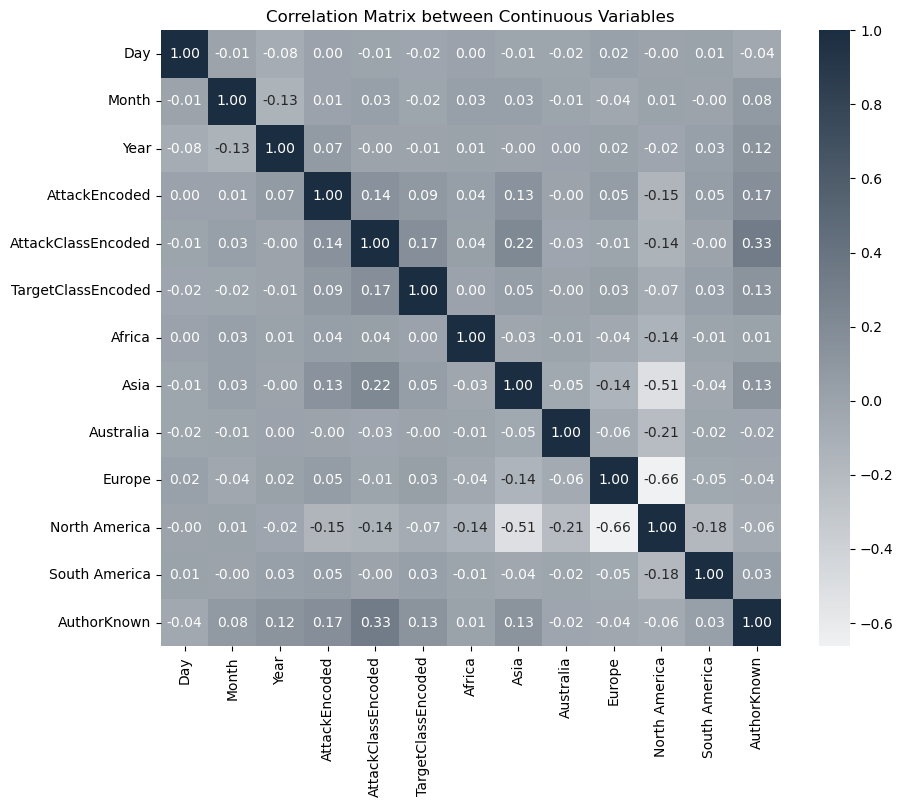

In [347]:
correlation_matrix = df_1.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=denexus_palette, fmt=".2f")
plt.title('Correlation Matrix between Continuous Variables')
plt.show()

#### División en Conjuntos de Entrenamiento y Prueba.

In [348]:
X = df_1.drop(['AuthorKnown'], axis=1)
y = df_1['AuthorKnown']

In [349]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)

In [350]:
y_train.value_counts()

0    2694
1    1269
Name: AuthorKnown, dtype: int64

In [351]:
y_test.value_counts()

0    665
1    326
Name: AuthorKnown, dtype: int64

#### Manejo de variables desbalanceadas.
Dado el desbalance de clases en el conjunto de entrenamiento, vamos a aplicar **Random Over-Sampling (ROS)** para equilibrar las clases minoritarias. Esta técnica aumenta la representación de las clases menos frecuentes duplicando aleatoriamente sus instancias, lo que permite que el modelo aprenda de manera más equitativa.

In [352]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#### Entrenamiento y Evaluación de Modelos.
En este apartado, entrenaremos modelos de aprendizaje supervisado para predecir el si el autor fue conocido o no.

##### **Random Forest.**
**Random Forest** es un algoritmo de aprendizaje automático basado en la creación de múltiples árboles de decisión, cuyos resultados se combinan para mejorar la precisión y evitar el sobreajuste.

In [353]:
rf_model = RandomForestClassifier(random_state=42,)
rf_model.fit(X_train_ros, y_train_ros)

RandomForestClassifier(random_state=42)

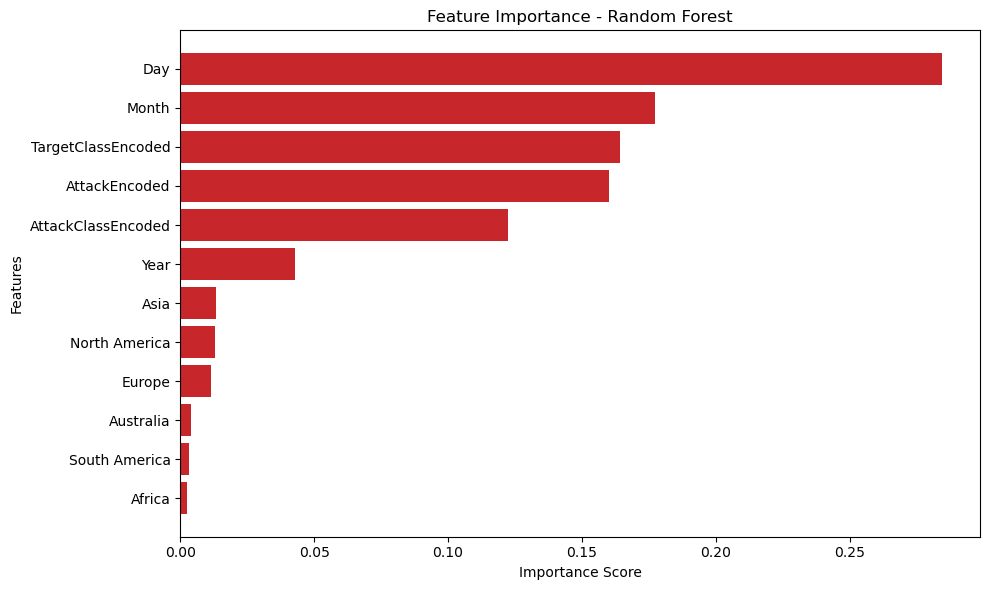

In [354]:
feature_importances = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], align='center', color= denexus_colors[2])
plt.gca().invert_yaxis()
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "feature-importance_random-forest.png")
    plt.savefig(output_path)
plt.show()

In [355]:
cv_scores = cross_val_score(rf_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.84137291, 0.8432282 , 0.86085343, 0.88765088, 0.90343547])

In [356]:
print("Train set score (Accuracy) =", rf_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", rf_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, rf_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, rf_model.predict(X_test)))

Train set score (Accuracy) = 0.9860801781737194
Test set score (Accuracy) = 0.7436932391523713
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            540 │            125 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            129 │            197 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       665
           1       0.61      0.60      0.61       326

    accuracy                           0.74       991
   macro avg       0.71      0.71      0.71       991
weighted avg       0.74      0.74      0.74       991



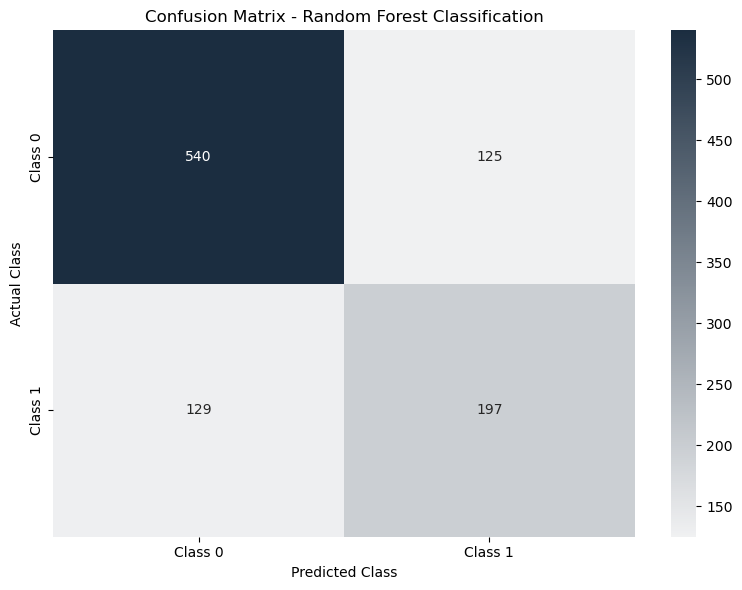

In [357]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - Random Forest Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_random-forest.png")
    plt.savefig(output_path)
plt.show()

##### **KNeighbors.**

In [358]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_ros, y_train_ros)

KNeighborsClassifier()

In [359]:
cv_scores = cross_val_score(knn_model, X_train_ros, y_train_ros, cv=5, scoring='accuracy')
cv_scores

array([0.67346939, 0.70222635, 0.69480519, 0.72887651, 0.72980501])

In [360]:
print("Train set score (Accuracy) =", knn_model.score(X_train_ros, y_train_ros))
print("Test set score (Accuracy) =", knn_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, knn_model.predict(X_test))

num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, knn_model.predict(X_test)))

Train set score (Accuracy) = 0.8307349665924276
Test set score (Accuracy) = 0.6528758829465187
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            462 │            203 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            141 │            185 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       665
           1       0.48      0.57      0.52       326

    accuracy                           0.65       991
   macro avg       0.62      0.63      0.62       991
weighted avg       0.67      0.65      0.66       991



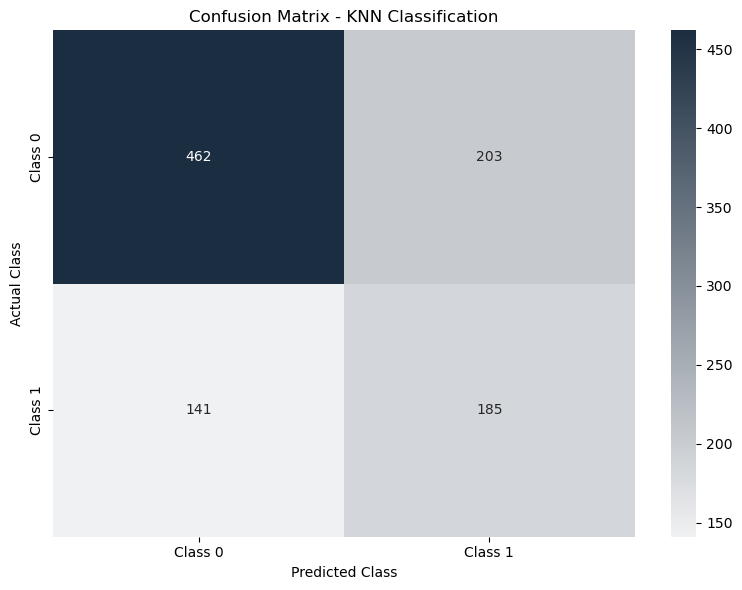

In [361]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - KNN Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_knn.png")
    plt.savefig(output_path)
plt.show()

##### **XGBoost Model.**

In [362]:
xgboost_model = XGBClassifier(eval_metric='logloss')

In [363]:
xgboost_model.fit(X_train_ros, y_train_ros)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [364]:
Y_pred_xgb = xgboost_model.predict(X_train_ros)
print("XGBoost Classification Report:\n")
print("Test set score (Accuracy) =", xgboost_model.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, xgboost_model.predict(X_test))
num_classes = conf_mat.shape[0]

print(tabulate(
    conf_mat,
    headers=[f'Pred Class {i}' for i in range(num_classes)],
    showindex=[f'Real Class {i}' for i in range(num_classes)],
    tablefmt='fancy_grid'
))

print("\nClassification Report:")
print(classification_report(y_test, xgboost_model.predict(X_test)))

XGBoost Classification Report:

Test set score (Accuracy) = 0.739656912209889
╒══════════════╤════════════════╤════════════════╕
│              │   Pred Class 0 │   Pred Class 1 │
╞══════════════╪════════════════╪════════════════╡
│ Real Class 0 │            516 │            149 │
├──────────────┼────────────────┼────────────────┤
│ Real Class 1 │            109 │            217 │
╘══════════════╧════════════════╧════════════════╛

Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80       665
           1       0.59      0.67      0.63       326

    accuracy                           0.74       991
   macro avg       0.71      0.72      0.71       991
weighted avg       0.75      0.74      0.74       991



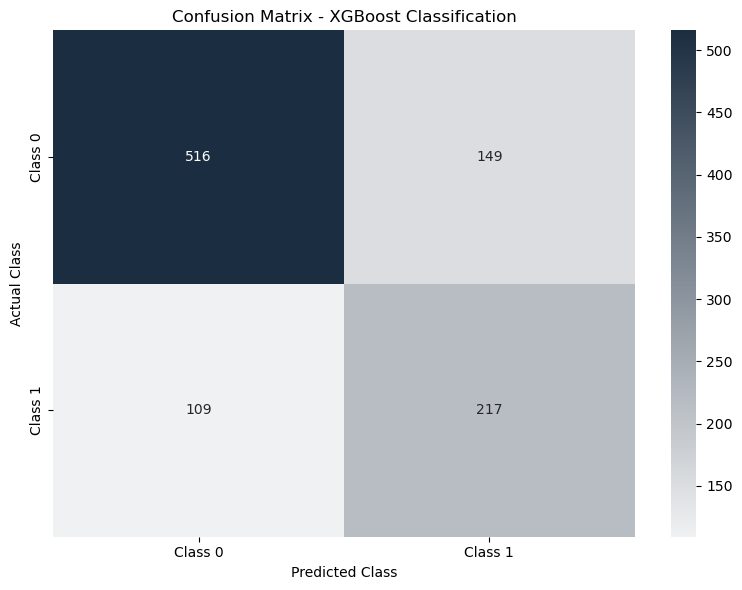

In [365]:
class_labels = [f'Class {i}' for i in range(conf_mat.shape[0])]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap=denexus_palette,
            xticklabels=class_labels, yticklabels=class_labels, cbar=True)
plt.title('Confusion Matrix - XGBoost Classification')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "confusion-matrix_xgboost.png")
    plt.savefig(output_path)
plt.show()

#### Curva ROC.

In [366]:
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_knn = knn_model.predict_proba(X_test)[:, 1]
y_prob_xgb = xgboost_model.predict_proba(X_test)[:, 1]

In [367]:
# Calcular FPR, TPR y el AUC.
## Random Forest.
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

## Decision Tree.
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

## XGBoost.
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

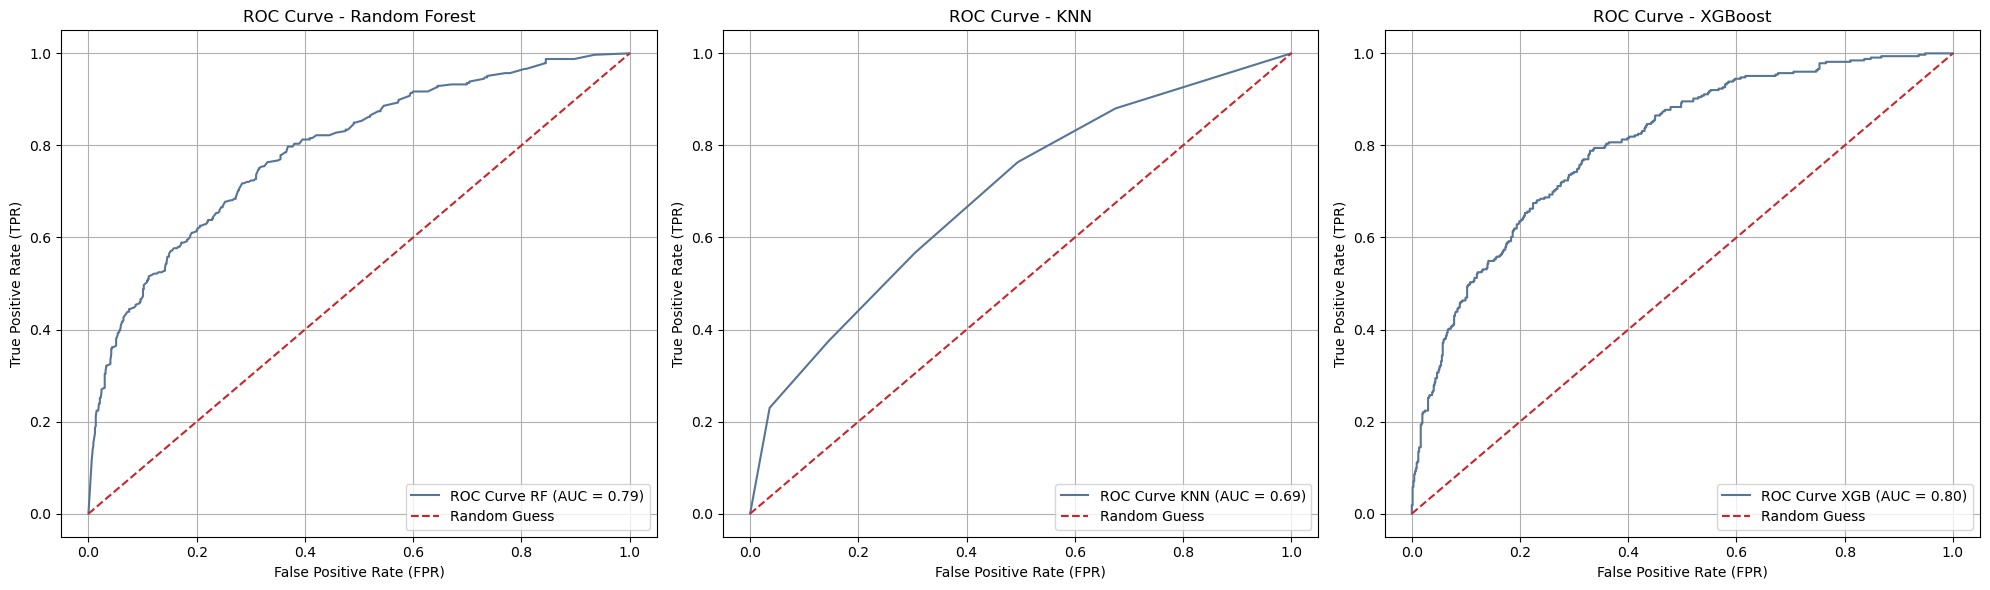

In [368]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

## Subplot para Random Forest.
axs[0].plot(fpr_rf, tpr_rf, label=f'ROC Curve RF (AUC = {roc_auc_rf:.2f})', color=denexus_colors[1])
axs[0].plot([0, 1], [0, 1], color=denexus_colors[2], linestyle='--', label='Random Guess')
axs[0].set_title('ROC Curve - Random Forest')
axs[0].set_xlabel('False Positive Rate (FPR)')
axs[0].set_ylabel('True Positive Rate (TPR)')
axs[0].legend(loc='lower right')
axs[0].grid(True)

## Subplot para Decision Tree.
axs[1].plot(fpr_knn, tpr_knn, label=f'ROC Curve KNN (AUC = {roc_auc_knn:.2f})', color=denexus_colors[1])
axs[1].plot([0, 1], [0, 1], color=denexus_colors[2], linestyle='--', label='Random Guess')
axs[1].set_title('ROC Curve - KNN')
axs[1].set_xlabel('False Positive Rate (FPR)')
axs[1].set_ylabel('True Positive Rate (TPR)')
axs[1].legend(loc='lower right')
axs[1].grid(True)

## Subplot para XGBoost.
axs[2].plot(fpr_xgb, tpr_xgb, label=f'ROC Curve XGB (AUC = {roc_auc_xgb:.2f})', color=denexus_colors[1])
axs[2].plot([0, 1], [0, 1], color=denexus_colors[2], linestyle='--', label='Random Guess')
axs[2].set_title('ROC Curve - XGBoost')
axs[2].set_xlabel('False Positive Rate (FPR)')
axs[2].set_ylabel('True Positive Rate (TPR)')
axs[2].legend(loc='lower right')
axs[2].grid(True)

plt.tight_layout()

# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "ROC-curves.png")
    plt.savefig(output_path)

plt.show()

#### Resultados.

In [369]:
rf_pred = rf_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
xgb_pred = xgboost_model.predict(X_test)

In [370]:
rf_precision = precision_score(y_test, rf_pred, average='weighted')
rf_recall = recall_score(y_test, rf_pred, average='weighted')

In [371]:
knn_precision = precision_score(y_test, knn_pred, average='weighted')
knn_recall = recall_score(y_test, knn_pred, average='weighted')

In [372]:
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')

In [373]:
results['Model'] = ['RandomForest', 'KNN', 'XGBoost']
results['Accuracy'] = [rf_precision, knn_precision, xgb_precision]
results['Recall'] = [rf_recall, knn_recall, xgb_recall]

In [374]:
results

,Model,Tipo,Accuracy,Recall
0,RandomForest,Binary,0.742905,0.743693
1,KNN,Binary,0.670979,0.652876
2,XGBoost,Binary,0.749050,0.739657


### Modelos de Clasificación No Supervisados.

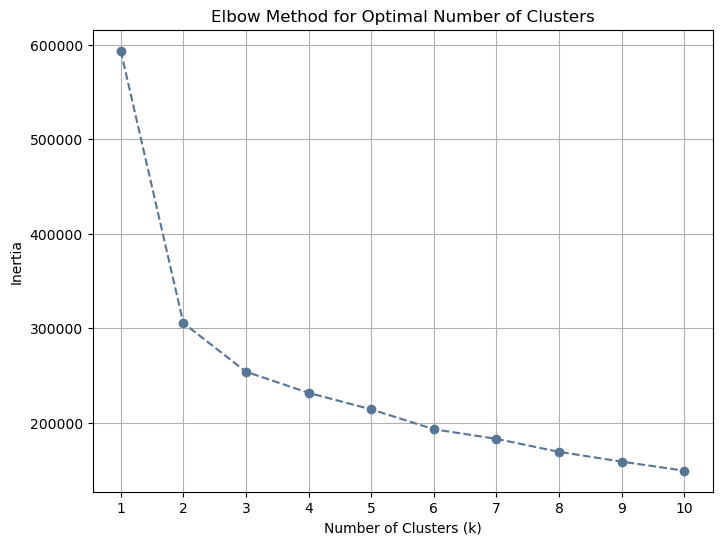

In [375]:
#Elbow method.
X_unsupervised = df_1.copy()
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_unsupervised)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--', color=denexus_colors[1])
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "elbow-method-kmeans.png")
    plt.savefig(output_path)
plt.show()

In [376]:
for k, score in zip(range(1, 11), inertia):
    print(f"Number of Clusters (k={k}): Inertia = {score:.4f}")

Number of Clusters (k=1): Inertia = 593490.5515
Number of Clusters (k=2): Inertia = 305343.6841
Number of Clusters (k=3): Inertia = 253818.8999
Number of Clusters (k=4): Inertia = 231445.2348
Number of Clusters (k=5): Inertia = 213958.6960
Number of Clusters (k=6): Inertia = 192884.4136
Number of Clusters (k=7): Inertia = 182765.2760
Number of Clusters (k=8): Inertia = 169002.9547
Number of Clusters (k=9): Inertia = 158642.9574
Number of Clusters (k=10): Inertia = 149032.3711


In [377]:
#KMeans.
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_unsupervised)

KMeans(n_clusters=6, random_state=42)

In [378]:
X_unsupervised['Cluster'] = kmeans.predict(X_unsupervised)

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")

Optimal number of clusters: 6
Inertia for optimal_k (6): 192884.4136


Optimal number of clusters: 6
Inertia for optimal_k (6): 192884.4136
Silhouette Score (Average): 0.2552


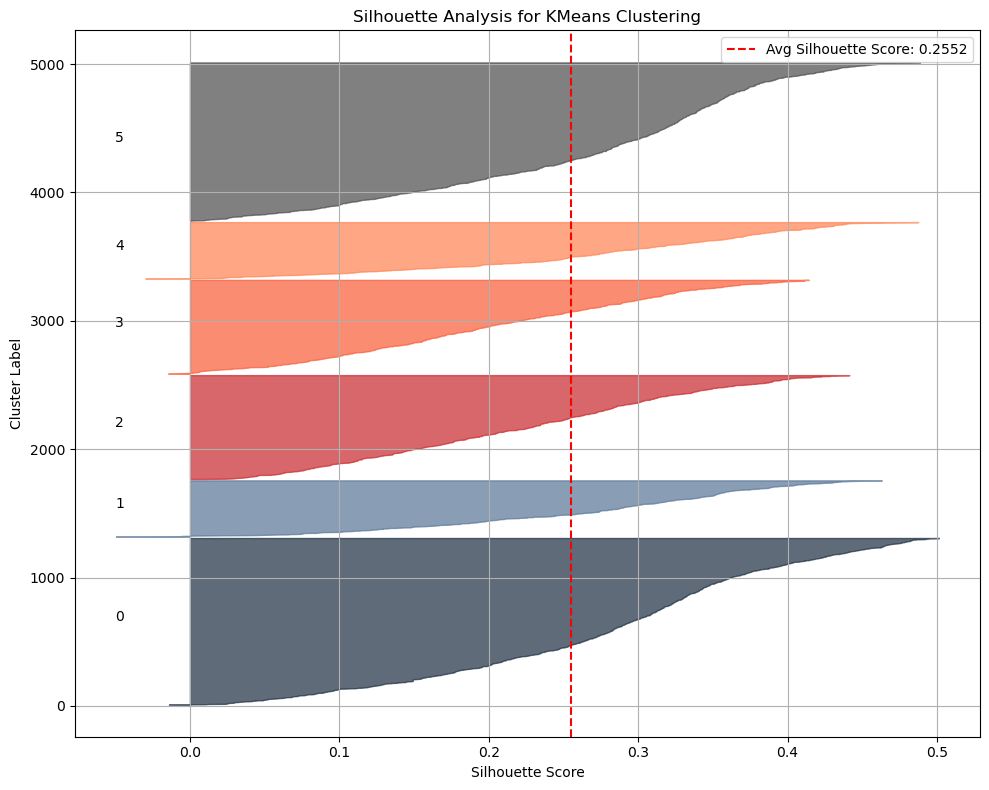

In [379]:
silhouette_avg = silhouette_score(X_unsupervised, X_unsupervised['Cluster'])
silhouette_values = silhouette_samples(X_unsupervised, X_unsupervised['Cluster'])

print(f"Optimal number of clusters: {optimal_k}")
print(f"Inertia for optimal_k ({optimal_k}): {kmeans.inertia_:.4f}")
print(f"Silhouette Score (Average): {silhouette_avg:.4f}")

# Gráfico de silueta
plt.figure(figsize=(10, 8))
y_lower = 10

for i in range(optimal_k):
    cluster_silhouette_values = silhouette_values[X_unsupervised['Cluster'] == i]
    cluster_silhouette_values.sort()
    cluster_size = len(cluster_silhouette_values)
    y_upper = y_lower + cluster_size
    
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        cluster_silhouette_values,
        alpha=0.7,
        color=denexus_colors[i % len(denexus_colors)]
    )
    plt.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10  # Espacio entre clusters

plt.axvline(x=silhouette_avg, color="red", linestyle="--", label=f"Avg Silhouette Score: {silhouette_avg:.4f}")
plt.title("Silhouette Analysis for KMeans Clustering")
plt.xlabel("Silhouette Score")
plt.ylabel("Cluster Label")
plt.legend()
plt.grid()
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "silhouette-analysis-kmeans-cluster.png")
    plt.savefig(output_path)
plt.show()

## Visualización de las gráficas.

### Distribución de Author, Attack y Target Class.

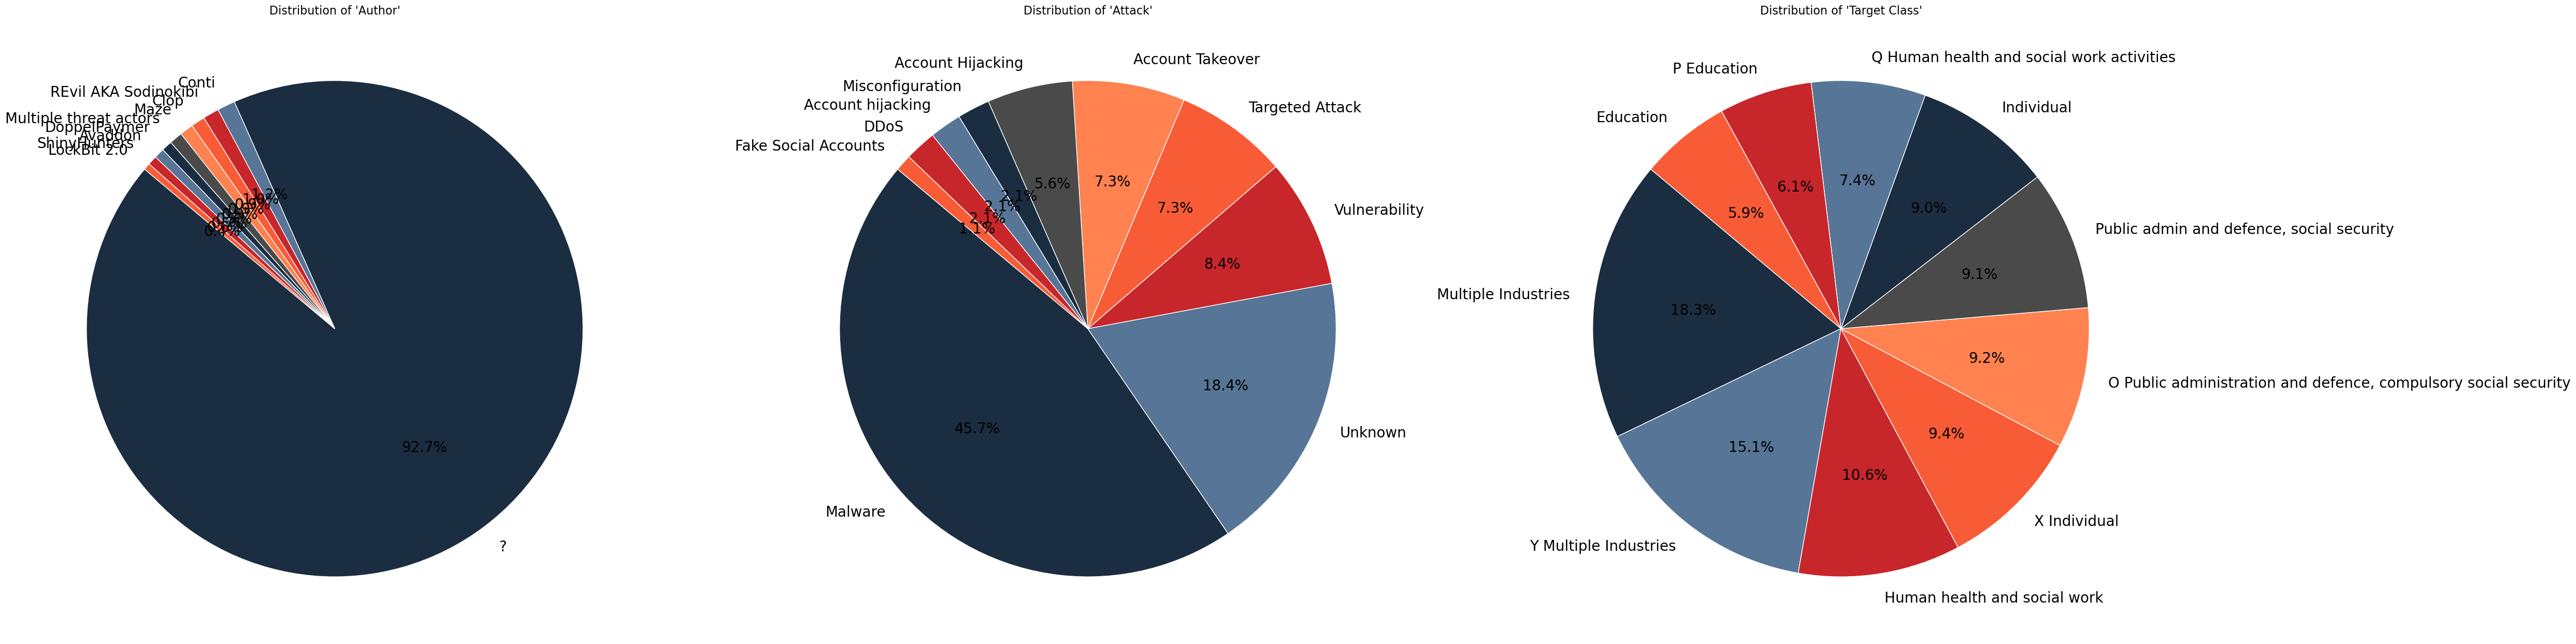

In [380]:
import matplotlib.pyplot as plt

# Configuración de colores.
cmap = plt.get_cmap('tab20')

# Crear la figura y los subplots.
fig, axs = plt.subplots(1, 3, figsize=(50, 25))

# Gráfico para 'Author'.
freq_author = df['Author'].value_counts().head(10)
axs[0].pie(
    freq_author.values,
    labels=freq_author.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=denexus_colors[:len(freq_author)],
    textprops={'fontsize': 20},
    wedgeprops={'edgecolor': 'white'}
)
axs[0].set_title("Distribution of 'Author'", fontsize=16)

# Gráfico para 'Attack'.
freq_attack = df['Attack'].value_counts().head(10)
axs[1].pie(
    freq_attack.values,
    labels=freq_attack.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=denexus_colors[:len(freq_attack)],
    textprops={'fontsize': 20},
    wedgeprops={'edgecolor': 'white'}
)
axs[1].set_title("Distribution of 'Attack'", fontsize=16)

# Gráfico para 'Target Class'.
freq_target = df['Target Class'].value_counts().head(10)
axs[2].pie(
    freq_target.values,
    labels=freq_target.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=denexus_colors[:len(freq_target)],
    textprops={'fontsize': 20},
    wedgeprops={'edgecolor': 'white'}
)
axs[2].set_title("Distribution of 'Target Class'", fontsize=16)
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "distributions.png")
    plt.savefig(output_path)
plt.show()

### Top 10 valores de Author, Attack y Target Class.

<Figure size 1000x600 with 0 Axes>

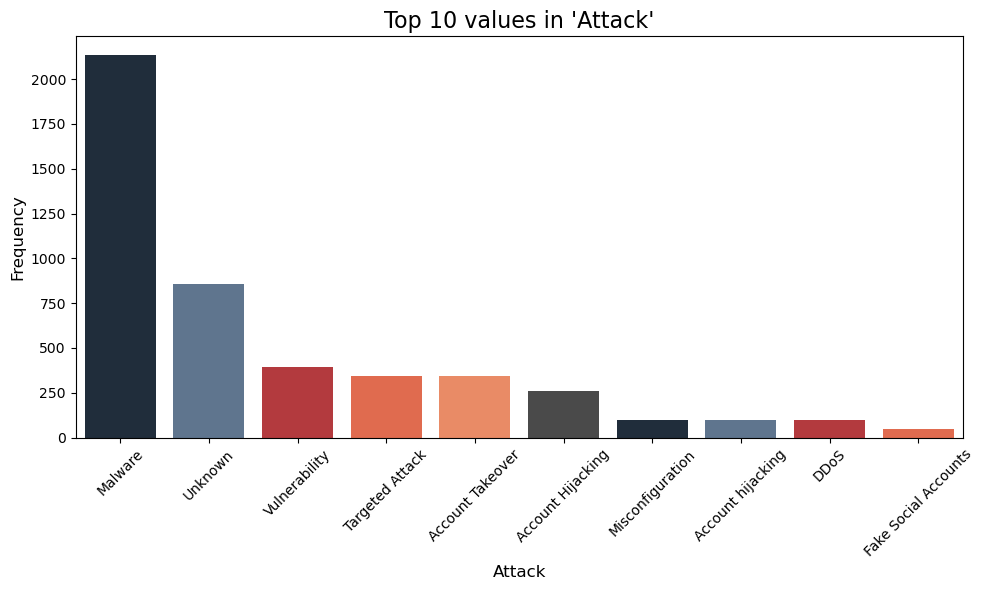

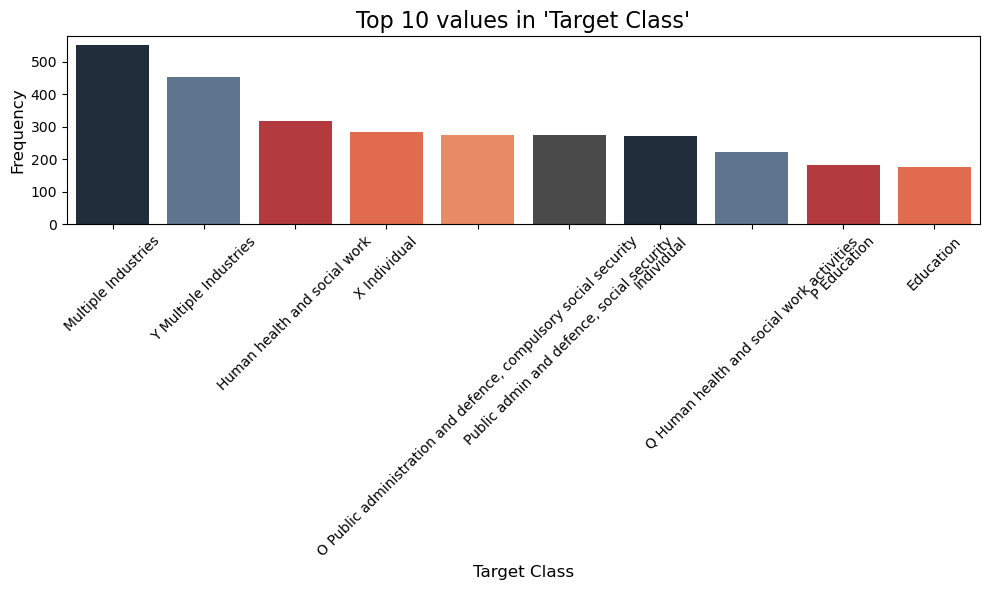

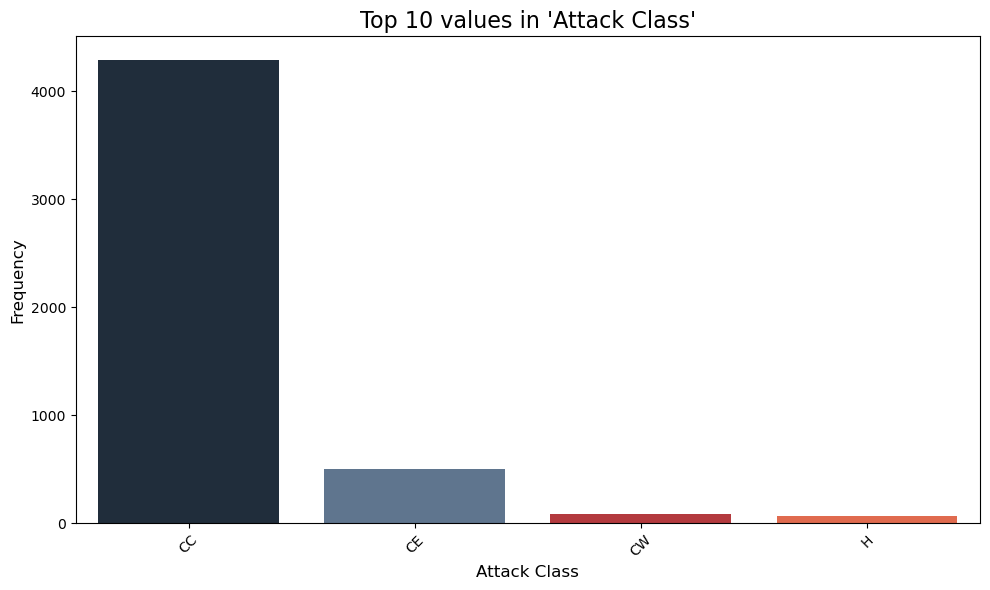

In [381]:
# Definir el tamaño de la figura para los gráficos
plt.figure(figsize=(10, 6))

# Lista de columnas a graficar
columns_to_plot = ['Attack', 'Target Class', 'Attack Class']

# Crear gráficos de barras para las columnas categóricas
for col in columns_to_plot:
    plt.figure(figsize=(10, 6))
    freq = df[col].value_counts().head(10)  # Top 10 categorías
    sns.barplot(x=freq.index, y=freq.values, palette=denexus_colors)
    plt.title(f"Top 10 values in '{col}'", fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    # Guardar el gráfico en la carpeta 'plots'.
    output_dir = "plots"
    if os.path.exists(output_dir) and os.path.isdir(output_dir):
        output_path = os.path.join(output_dir, f"{col}-distribution.png")
        plt.savefig(output_path)
    plt.show()

### Tendencias a lo largo del tiempo.

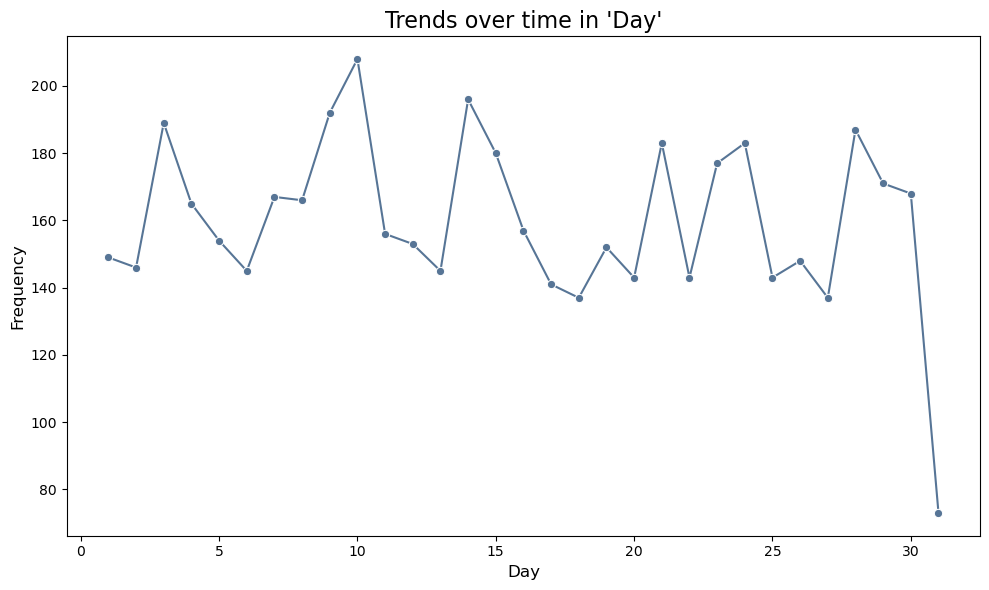

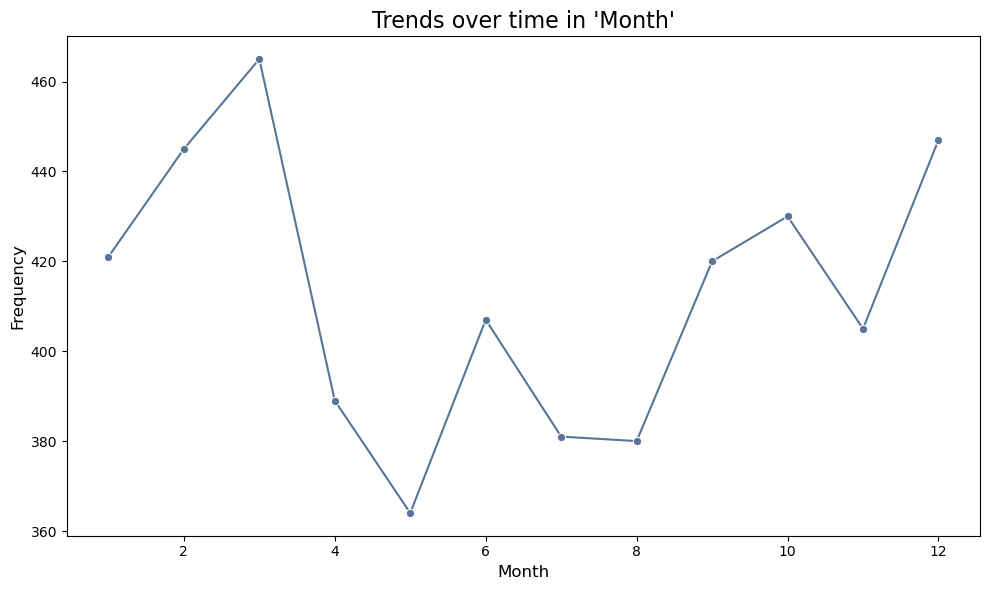

In [382]:
time_columns = ['Day', 'Month']
for col in time_columns:
    plt.figure(figsize=(10, 6))
    freq = df[col].value_counts().sort_index()  # Ordenar por fecha o año
    sns.lineplot(x=freq.index, y=freq.values, marker='o', color=denexus_colors[1])
    plt.title(f"Trends over time in '{col}'", fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.tight_layout()
    # Guardar el gráfico en la carpeta 'plots'.
    output_dir = "plots"
    if os.path.exists(output_dir) and os.path.isdir(output_dir):
        output_path = os.path.join(output_dir, f"{col}-trends.png")
        plt.savefig(output_path)
    plt.show()

### Distribución de ataques por región.

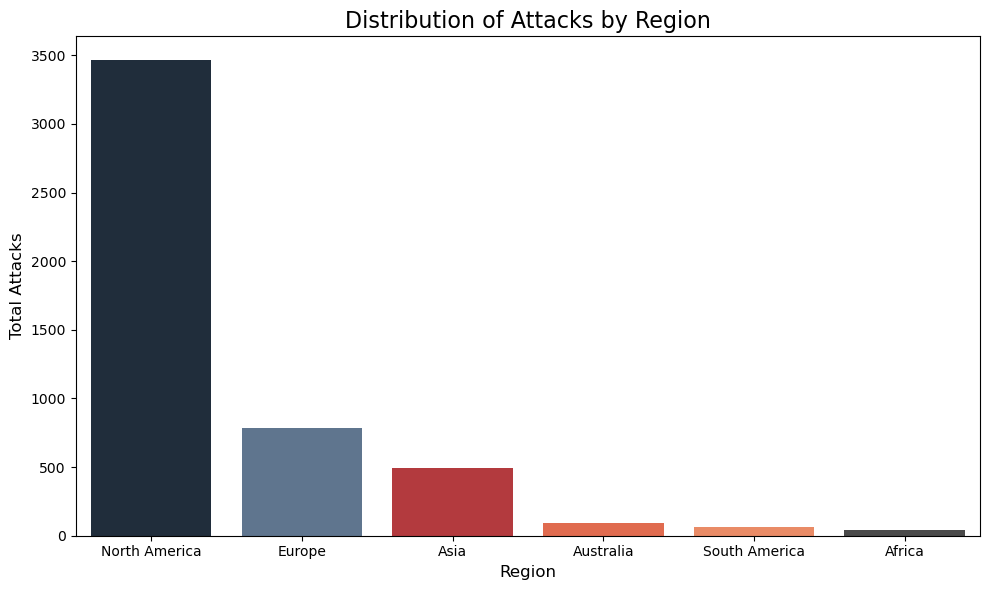

In [383]:
regions = ['Africa', 'Asia', 'Europe', 'North America', 'Australia', 'South America']
df_regions = df[regions].sum()
df_regions = df_regions.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=df_regions.index, y=df_regions.values, palette=denexus_colors)
plt.title("Distribution of Attacks by Region", fontsize=16)
plt.xlabel('Region', fontsize=12)
plt.ylabel('Total Attacks', fontsize=12)
plt.tight_layout()
# Guardar el gráfico en la carpeta 'plots'.
output_dir = "plots"
if os.path.exists(output_dir) and os.path.isdir(output_dir):
    output_path = os.path.join(output_dir, "attacks-by-region.png")
    plt.savefig(output_path)
plt.show()


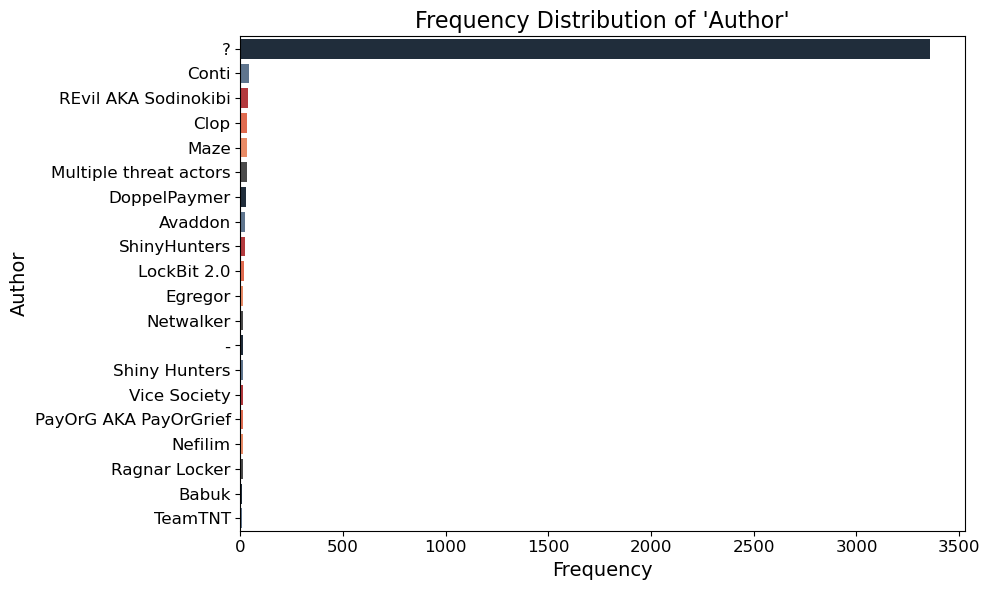

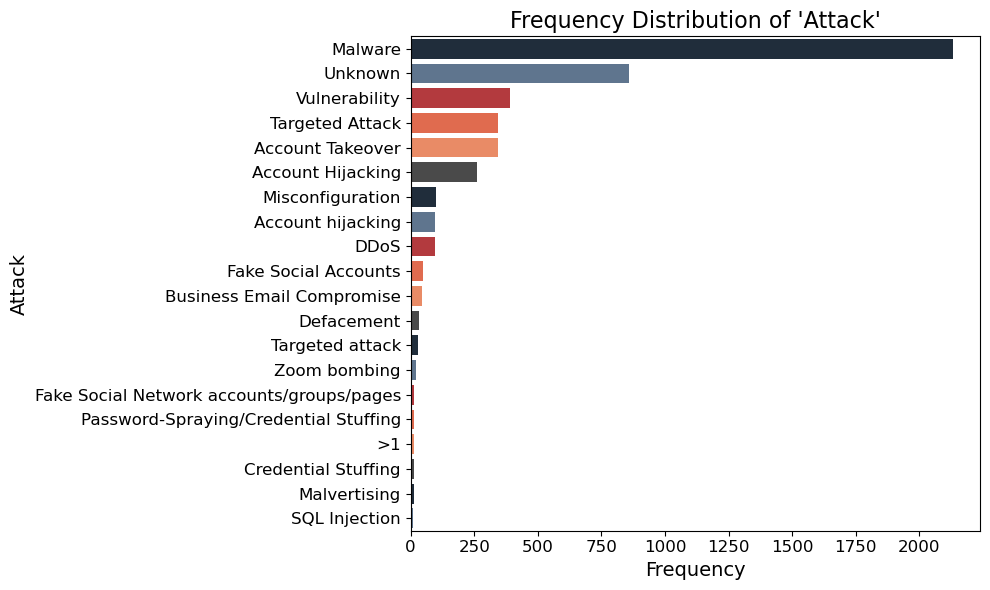

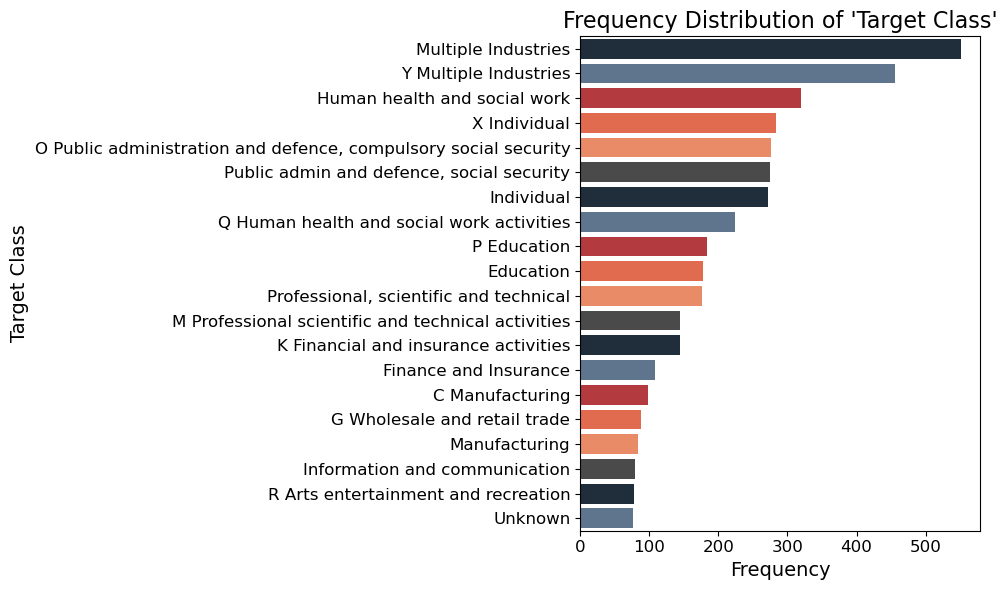

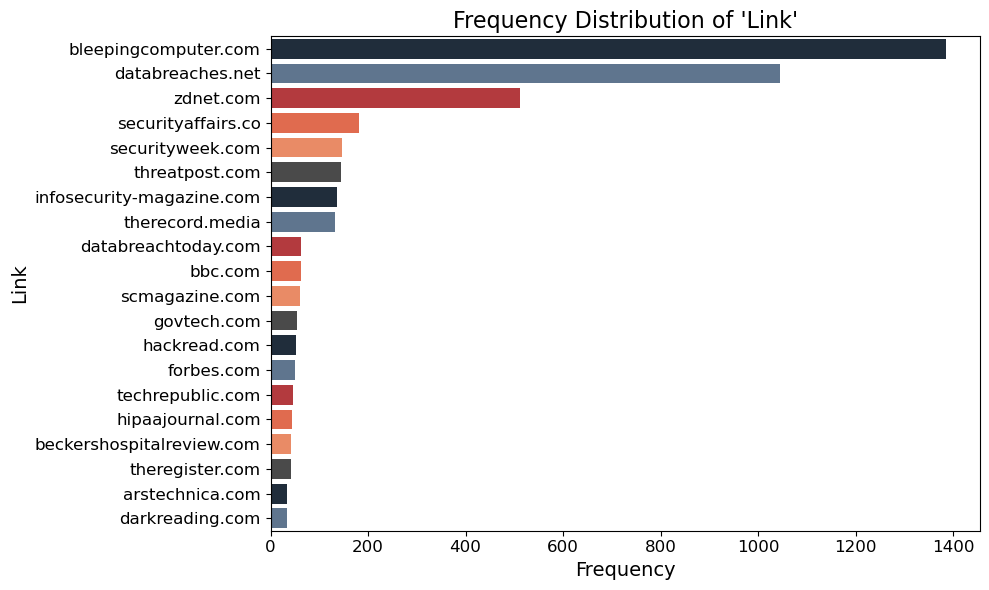

In [384]:
columns_to_analyze = ['Author', 'Attack', 'Target Class', 'Link']

for col in columns_to_analyze:
    plt.figure(figsize=(10, 6))
    freq = df[col].value_counts().head(20)
    sns.barplot(x=freq.values, y=freq.index, palette=denexus_colors)
    
    # Títulos y etiquetas
    plt.title(f"Frequency Distribution of '{col}'", fontsize=16)
    plt.xlabel("Frequency", fontsize=14)
    plt.ylabel(col, fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    # Guardar el gráfico en la carpeta 'plots'.
    output_dir = "plots"
    if os.path.exists(output_dir) and os.path.isdir(output_dir):
        output_path = os.path.join(output_dir, f"{col}-frequency-distribution.png")
        plt.savefig(output_path)
    plt.show()
